In [1]:
# RFM (Recency, Frequency, Monetary/Value model)

import datetime
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
def load_file(path, file_name):
    df = pd.read_csv(path + file_name)
    
    cols = ['activity', 'duration', 'completion', 'Is Manager']
    actor_df = df.groupby('actorId')[cols].agg({'activity': 'count',
                                                'duration': 'sum',
                                                'completion': 'sum',
                                                'Is Manager': 'last'
                                                }).reset_index()
    
    actor_df['actorId'] = actor_df['actorId'].str.split('|').str[-1]
    actor_df['date'] = file_name.replace('.csv', '')

    return actor_df

In [3]:
# Loop individual json files
data_dir = './data/'
file_list = [file for file in os.listdir(data_dir) if file.endswith('.csv')]
file_list = [file for file in file_list if file != 'activities.csv']
# file_list = file_list[:30]

In [4]:
data = [load_file(data_dir, x) for x in file_list]

C:\Users\mnelo\anaconda3\envs\py_cpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\mnelo\anaconda3\envs\py_cpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df = pd.concat(data)

In [6]:
df.head()

,actorId,activity,duration,completion,Is Manager,date
0,00030190-dcc0-11ea-892f-13bace717482,20,321363,0.0,N,2021-07-01
1,00082fb1414f9f1513402b02ee0fbc703bc30418c4be55...,1,832,1.0,N,2021-07-01
2,003e7061b23d9b921a4d3500105e76e848c65572f160e4...,22,93299,13.0,N,2021-07-01
3,004dd7c1cd54a30e42cdd675f8ca6734361eeeaf65c708...,2,6158,0.0,N,2021-07-01
4,00553ab7ac5ea7881594583157d965b82f85dc5820c31b...,4,18846,0.0,N,2021-07-01


In [7]:
# Convert to monthly signals
df['month'] = pd.to_datetime(df['date']).dt.month
month_df = df.groupby(['month', 'actorId']).agg({'date': 'max',
                                                 'activity': 'count',
                                                 'duration': 'sum',
                                                 'completion': 'sum',
                                                 'Is Manager': 'last'}).reset_index()

In [8]:
# Transform month for cyclical feature
month_df['month_sin'] = np.sin((month_df['month'] - 1)*(2.*np.pi/12))
month_df['month_cos'] = np.cos((month_df['month'] - 1)*(2.*np.pi/12))
month_df['date'] = pd.to_datetime(month_df['date'])

In [9]:
month_df.sort_values(['actorId', 'date'], inplace=True)
month_df.head()

,month,actorId,date,activity,duration,completion,Is Manager,month_sin,month_cos
242834,5,++9x+R2W6d3bmO29wJLkvMKT77vDkeC+Xyj8LA==,2022-05-31,3,498009,15.0,N,8.660254e-01,-5.000000e-01
526029,9,++IXItP1roBROE0cZzVGHGI0SBRsPEgWm1AsEQ==,2021-09-29,2,399042,5.0,N,-8.660254e-01,-5.000000e-01
599388,10,++IXItP1roBROE0cZzVGHGI0SBRsPEgWm1AsEQ==,2021-10-26,3,524836,16.0,N,-1.000000e+00,-1.836970e-16
189779,4,++IXItP1roBROE0cZzVGHGI0SBRsPEgWm1AsEQ==,2022-04-24,1,23590,0.0,N,1.000000e+00,6.123234e-17
385245,7,++R0/LJbYJhMnOm4wpjqvceV47XOmOm3OvGNvw==,2021-07-17,3,256667,4.0,N,1.224647e-16,-1.000000e+00


In [10]:
dates = [datetime.date(2021, x, 1) - datetime.timedelta(days=1) for x in range(8, 13)] 
dates = dates + [datetime.date(2022, x, 1) - datetime.timedelta(days=1) for x in range(1, 8)]
dates = [pd.to_datetime(x) for x in dates]
dates

[Timestamp('2021-07-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00'),
 Timestamp('2021-09-30 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-31 00:00:00'),
 Timestamp('2022-02-28 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-05-31 00:00:00'),
 Timestamp('2022-06-30 00:00:00')]

In [11]:
data_transform = []

for x, y in zip(dates[:-1], dates[1:]):
    feature_filter = month_df['date'] <= x
    label_filter = (month_df['date'] > x) & (month_df['date'] <= y)
    
    features = month_df.loc[feature_filter]
    labels = month_df.loc[label_filter, ['actorId', 'completion']]
    
    # Feature engineering
    features = features.groupby('actorId').agg({'date': 'max', 
                                                'activity': 'sum', 
                                                'duration': 'sum', 
                                                'Is Manager': 'last',
                                                'month_sin': 'last',
                                                'month_cos': 'last'}).reset_index()
    features['recency'] = (x - features['date']).dt.days
    features['manager'] = np.where(features['Is Manager'] == 'Y', 1, 0)
    features = features[['actorId', 'recency', 'activity', 'duration', 'manager', 'month_sin', 'month_cos']]
    
    # Merge with t+1 labels
    new_data = pd.merge(left=features,
                        right=labels,
                        how='left',
                        on='actorId')
    new_data['completion'].fillna(0, inplace=True)
    
    data_transform.append(new_data)
    
df_transform = pd.concat(data_transform)

In [12]:
df_transform.head()

,actorId,recency,activity,duration,manager,month_sin,month_cos,completion
0,++R0/LJbYJhMnOm4wpjqvceV47XOmOm3OvGNvw==,14,3,256667,0,1.224647e-16,-1.0,0.0
1,++URvSHxYSVFVyJzCFsqdQlbL3kGUCF/8jlFdw==,26,2,29792,1,1.224647e-16,-1.0,3.0
2,+/1xMsbUkzW4u86e47HHneW+zpLsv8yScwTQGw==,3,3,871526,0,1.224647e-16,-1.0,2.0
3,+/Dj4o6M7FkESTxtGU06Zx9NPmIYSjBu4yhUaQ==,25,1,518194,0,1.224647e-16,-1.0,0.0
4,+/Sa03htBsFXqt+O9K7dgf6r34jxoteJBM+zjg==,0,2,159410,0,1.224647e-16,-1.0,0.0


In [13]:
# Train/Test split
X = df_transform[['recency', 'activity', 'duration', 'manager', 'month_sin', 'month_cos']]
y = df_transform[['completion']].values.reshape(-1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [14]:
# Feature scaling
norm = StandardScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [15]:
def evaluate_model(rf, X_train, y_train, X_test, y_test):
    # Predictions
    predictions = pd.DataFrame()
    predictions['true'] = y_train
    predictions['preds'] = rf.predict(X_train)

    predictions_test = pd.DataFrame()
    predictions_test['true'] = y_test
    predictions_test['preds'] = rf.predict(X_test)
    
    # Evaluation
    train_rmse = mean_squared_error(predictions.true, predictions.preds) ** 0.5
    test_rmse = mean_squared_error(predictions_test.true, predictions_test.preds) ** 0.5

    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

In [117]:
# Fit model
rf = RandomForestRegressor().fit(X_train, y_train)

In [119]:
evaluate_model(rf, X_train, y_train, X_test, y_test)

Train RMSE: 6.411795259868778, Test RMSE: 17.070324982822264


In [120]:
# Hyperparameter turning
### VERY SLOW
n_estimators = [100, 500, 1000, 2000]
max_depth = [None, 2, 4, 6, 8, 10]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [17]:
# Random parameters
rf_rand = RandomForestRegressor(n_estimators=1000,
                                max_depth=6,
                                min_samples_split=5).fit(X_train, y_train)
evaluate_model(rf_rand, X_train, y_train, X_test, y_test)

Train RMSE: 15.877138665338167, Test RMSE: 15.918603286261106


In [89]:
from sklearn.inspection import permutation_importance

In [90]:
result = permutation_importance(rf_rand, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T,
                           columns=X.columns[sorted_importances_idx])

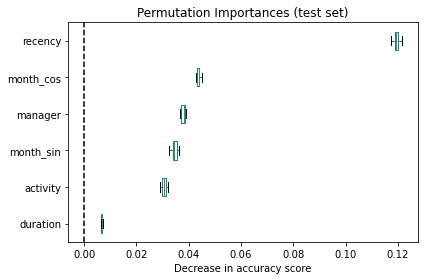

In [92]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [21]:
import xgboost as xgb

In [28]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest =  xgb.DMatrix(data=X_test, label=y_test)

In [75]:
xg_params = {'objective': 'reg:squarederror',
             'booster': 'gbtree',
             'learning_rate': 0.1,
             'max_depth': 6, 
             'max_features': 'sqrt',
             'eval_metric': 'rmse',
             'seed': 42}

In [80]:
xg_fit = xgb.train(xg_params, dtrain, num_boost_round=100)

[15:38:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [81]:
preds_train = xg_fit.predict(dtrain)
preds_test = xg_fit.predict(dtest)

train_rmse = mean_squared_error(y_train, preds_train) ** 0.5
test_rmse = mean_squared_error(y_test, preds_test) ** 0.5

print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 15.624955303958346, Test RMSE: 15.83826331215991


In [85]:
import shap

In [86]:
explainer = shap.TreeExplainer(xg_fit)
shap_values = explainer.shap_values(X_test)

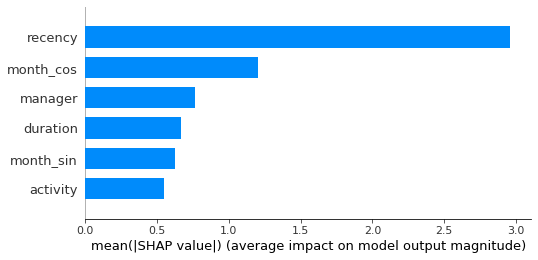

In [87]:
shap.summary_plot(shap_values, X_test, plot_type="bar")